## Congressional Networks via Voting Probabilities
### Jeremy Kazimer
### Dane Taylor
### 6/15/2021

#### _Import Statements_

In [1]:
# Data structures
import numpy as np
import pandas as pds

# System and utility
import os, sys
sys.path.append('utility')

from get_voteview import *
from form_networks import *
from VNE_util import *

# Plots and graphs
from matplotlib import pyplot as plt
from matplotlib import colors as cm
import networkx as nx

#### _Get a Network_

We begin by fetching a network relating to a **chamber** and a corresponding **session**.  For the former, the choices are either 'Senate' or 'House' and for the latter an integer $n \in \left[1, 117\right]$.  Anything outside of these choices will produce empty results.  

For the purposes of this experiment, we'll be looking at the 117th Senate:

In [2]:
session = 117
chamber = 'Senate'

Now, we can get a few dataframes.  First, looking at the different political parties that occur in this session:

In [3]:
get_parties(session, chamber)

,congress,chamber,party_code,party_name,n_members,nominate_dim1_median,nominate_dim2_median,nominate_dim1_mean,nominate_dim2_mean
0,117,President,100,Democrat,1,-0.3200,0.283,-0.320000,0.283000
1,117,President,200,Republican,1,0.4030,0.162,0.403000,0.162000
2,117,Senate,100,Democrat,49,-0.3480,-0.122,-0.348388,-0.106245
3,117,Senate,200,Republican,51,0.4980,0.007,0.523627,0.020863
4,117,Senate,328,Independent,2,-0.3475,-0.304,-0.347500,-0.304000


We can also fetch a dataframe for how each member of this chamber voted and their identities:

In [4]:
votes = get_votes(session, chamber)
votes.head()

,congress,chamber,rollnumber,icpsr,cast_code,prob
0,117,Senate,1,14226.0,6,97.8
1,117,Senate,1,14307.0,6,100.0
2,117,Senate,1,14435.0,6,100.0
3,117,Senate,1,14858.0,6,100.0
4,117,Senate,1,14871.0,6,100.0


In [5]:
ideas = get_ideology(session, chamber)
ideas.head()

,congress,chamber,icpsr,state_icpsr,district_code,state_abbrev,party_code,occupancy,last_means,bioname,...,died,nominate_dim1,nominate_dim2,nominate_log_likelihood,nominate_geo_mean_probability,nominate_number_of_votes,nominate_number_of_errors,conditional,nokken_poole_dim1,nokken_poole_dim2
0,117,President,99912,99,0,USA,200,0.0,0.0,"TRUMP, Donald John",...,NaN,0.403,0.162,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,117,President,99913,99,0,USA,100,0.0,0.0,"BIDEN, Joseph Robinette, Jr.",...,NaN,-0.320,0.283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,117,Senate,42102,41,0,AL,200,NaN,NaN,"TUBERVILLE, Thomas Hawley (Tommy)",...,NaN,0.936,-0.352,-68.47279,0.91082,733.0,25.0,NaN,0.892,-0.220
3,117,Senate,94659,41,0,AL,200,NaN,NaN,"SHELBY, Richard C.",...,NaN,0.448,0.575,-132.16769,0.82545,689.0,71.0,NaN,0.546,0.491
4,117,Senate,40300,81,0,AK,200,NaN,NaN,"MURKOWSKI, Lisa",...,NaN,0.210,-0.302,-122.40980,0.83977,701.0,57.0,NaN,0.205,-0.374


Note that the Vice President is included in both dataframes, which we don't really want.  This is because she hasn't really cast any votes this session (so far) and as such will create a discontinuity.  Because of this, we'll remove her from the dataframe:

In [6]:
votes = votes[votes['icpsr'] < 99000]
ideas = ideas[ideas['icpsr'] < 99000]

for x in np.setdiff1d(ideas['icpsr'], votes['icpsr']):
    ideas = ideas[ideas['icpsr'] != x]

Now that she's been removed, we can get the adjacency matrix of this chamber and session:

In [7]:
V, remove_indices = get_voting_array(votes)
one_hot, p_ids, names = get_one_hot(votes, ideas, remove_indices)

# Note we're casting the independents to Democrats, since they caucus with them the most in recent history.
p_ids[p_ids == 328] = 100

# Reconstructing the one hot with this change.
one_hot = np.array((one_hot[:, 0] + one_hot[:, 2], one_hot[:, 1])).T
mask = one_hot @ one_hot.T

A, p_ids, one_hot, names = get_adjacency(V, p_ids, one_hot, names)

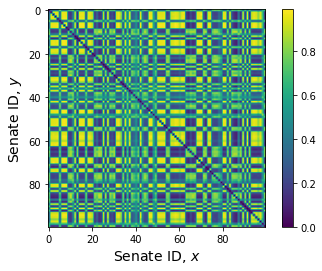

In [8]:
fig, ax = plt.subplots(1, 1)

colormap = ax.imshow(A)
ax.set_ylabel('Senate ID, $y$', fontsize = 14)
ax.set_xlabel('Senate ID, $x$', fontsize = 14)

fig.colorbar(colormap);

From this figure, it's not really apparent that there's structure in the data.  In order to do this, we can sort everything according to party affiliation because, in a party-based polarization, communities should exist along these identifiers.

In [9]:
p_sort = np.argsort(p_ids)
mask = mask[p_sort].T[p_sort]
one_hot = one_hot[p_sort]
names = names[p_sort]
A = A[p_sort].T[p_sort]

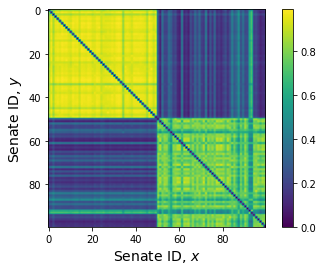

In [10]:
fig, ax = plt.subplots(1, 1)

colormap = ax.imshow(A)
ax.set_ylabel('Senate ID, $y$', fontsize = 14)
ax.set_xlabel('Senate ID, $x$', fontsize = 14)

fig.colorbar(colormap);

There's now community structure! We can take this a step further by thresholding by a nonzero scalar $t > 0$ to cause more of this community structure to be drawn out.  For this notebook, we experimentally settled on 0.40.

In [11]:
tA = (A > 0.40)*A

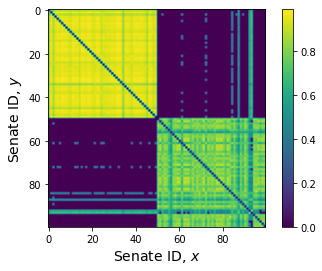

In [12]:
fig, ax = plt.subplots(1, 1)

colormap = ax.imshow(tA)
ax.set_ylabel('Senate ID, $y$', fontsize = 14)
ax.set_xlabel('Senate ID, $x$', fontsize = 14)

fig.colorbar(colormap);

We can quickly look at the weights of this network:

In [13]:
def no_locs_norm_hist(data, ax, color, label, alpha = 1):
    W = np.ones_like(data)/float(len(data))
    ax.hist(data, weights = W, color = color, label = label, bins = 20, alpha = alpha)

In [14]:
tA_triu = np.triu(tA)

in_weights = mask*tA_triu
in_weights = in_weights.flatten()
in_weights = in_weights[in_weights > 0]

out_weights = (1 - mask)*tA_triu
out_weights = out_weights.flatten()
out_weights = out_weights[out_weights > 0]

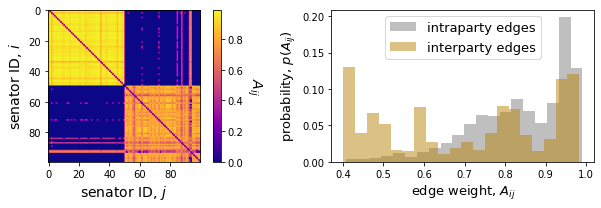

In [15]:
fig, axs = plt.subplots(1, 2, figsize = (9, 3))

ax2, ax1 = axs

no_locs_norm_hist(in_weights, ax1, 'grey', 'intraparty edges', alpha = 0.5)
no_locs_norm_hist(out_weights, ax1, 'darkgoldenrod', 'interparty edges', alpha = 0.5)

ax1.set_ylabel(r'probability, $p(A_{ij})$', fontsize = 13)
ax1.set_xlabel('edge weight, $A_{ij}$', fontsize = 13)
ax1.legend(loc = 'upper center', fontsize = 13)

colormap = ax2.imshow(tA, cmap = 'plasma')

ax2.set_ylabel('senator ID, $i$', fontsize = 14)
ax2.set_xlabel('senator ID, $j$', fontsize = 14)

ax3 = fig.colorbar(colormap, ax = ax2)
ax3.ax.set_ylabel(r'$A_{ij}$' + '\n', rotation = 270, fontsize = 14, labelpad = 20)

fig.tight_layout()

In [16]:
mask = one_hot @ one_hot.T

name_sort = np.argsort(-np.sum(((1 - mask)*tA), axis = 1))
names[name_sort][:7]

array(['COLLINS, Susan Margaret', 'MURKOWSKI, Lisa', 'GRAHAM, Lindsey O.',
       'PORTMAN, Robert Jones (Rob)', 'CAPITO, Shelley Moore',
       'ROMNEY, Willard Mitt (Mitt)', 'MANCHIN, Joe, III'], dtype=object)

At this threshold, all that's really remaining are the intraparty edges and the most significant interparty edges.  Now that we're at the network we wanted to be at, we can create a NetworkX plot:

In [17]:
party_colors = {100: '#0015bc', 200: '#e9141d'}
node_colors = [party_colors[val] for val in p_ids[p_sort]]

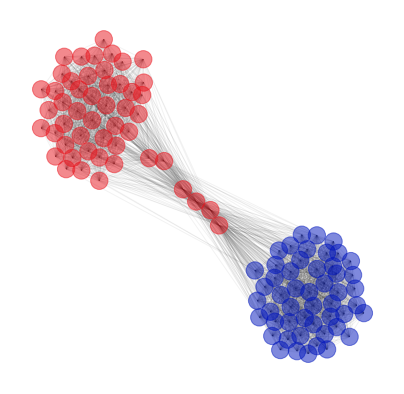

In [18]:
fig, ax = plt.subplots(1, 1, figsize = (7, 7))

G = nx.from_numpy_array(tA)
pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G.nodes, pos, ax = ax, node_color = node_colors, alpha = 0.5)
nx.draw_networkx_edges(G, pos, ax = ax, alpha = 0.05)

ax.axis('off');

With this, it is clear that the Republicans (red) are central to interparty communication with Democrats (blue).   

Lastly, we can save the network, the one hot and party ID's, $p_{in}$, and $p_{out}$ for use in another notebook.

In [19]:
in_edges = (mask*tA > 0).sum()/2
out_edges = (((1 - mask)*tA) > 0).astype(int).sum()/2

In [20]:
_, Ns = np.unique(p_ids, return_counts = True)

In [21]:
max_in_edges = np.sum(Ns*(Ns - 1)/2)
max_out_edges = (Ns*Ns[:, None])[0, 1]

In [22]:
p_in = in_edges/max_in_edges
p_out = out_edges/max_out_edges

In [23]:
print(p_in, p_out)

0.9959183673469387 0.0892


In [24]:
delta = p_in - p_out
rho = p_in - delta/2

#### _Comparing Congress to an SBM_

Now that we have viably constructed an adjacency matrix, we can compare this to an SBM with similar parameters.  First, we can define $\Delta = p_{in} - p_{out}$ such that we fix $p_{out}$:

In [25]:
delta1 = 0.250; pi1 = rho + delta1/2; po1 = rho - delta1/2
delta2 = 0.575; pi2 = rho + delta2/2; po2 = rho - delta2/2

And we can construct the networks associated with these values:

In [26]:
N = Ns.sum()
k = 2

G1, one_hot1 = SBM(N, pi1, po1, k)
G2, one_hot2 = SBM(N, pi2, po2, k)
G3, one_hot3 = SBM(N, p_in, p_out, k)

edges = get_edges(G1)
locs1 = get_edge_type(one_hot1, edges).astype(bool)

edges = get_edges(G2)
locs2 = get_edge_type(one_hot2, edges).astype(bool)

edges = get_edges(G3)
locs3 = get_edge_type(one_hot3, edges).astype(bool)

With that, we can find the normalized average rank across different $\beta$ for these graphs and also the Congressional network!

In [27]:
def avg_rank(G, locs, betas):
    avg_rank = np.zeros((betas.shape[0]))

    for idx, beta in enumerate(betas):
        _, _, ranks = modified_edge_rankings(G, beta, 1)
        avg_rank[idx] = ranks[~locs].mean()
        
    return avg_rank

In [28]:
betas = np.logspace(-2.5, 0.3, 51)

In [29]:
ranks1 = avg_rank(G1, locs1, betas)

In [30]:
ranks2 = avg_rank(G2, locs2, betas)

In [31]:
ranks3 = avg_rank(G3, locs3, betas)

And specifically for Congress:

In [32]:
con_edges = get_edges(tA)
con_locs = get_edge_type(one_hot, con_edges).astype(bool)
con_ranks = avg_rank(tA, con_locs, betas)

In [33]:
avg_beta = 1e-2
max_beta = 1e-1
min_beta = 1e0

At these values, we can look at both the edge distribution and the entropy distribution to compile into a larger figure.

In [34]:
Hs_avg, _, ranks_avg = modified_edge_rankings(tA, avg_beta, 1)
Hs_min, _, ranks_min = modified_edge_rankings(tA, min_beta, 1)
Hs_max, _, ranks_max = modified_edge_rankings(tA, max_beta, 1)

First, we should look at the NetworkX graph:

In [35]:
def nx_graph(G, pos, ranks, fig, ax, node_colors, cmap = plt.cm.gist_yarg, coloring = False):
    
    colors = ranks
    
    nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size = 30, ax = ax, alpha = 0.55)
    edges = nx.draw_networkx_edges(G, pos, edge_color = colors, width = 1,
                           edge_cmap=cmap, alpha = 0.4, ax = ax)
    
    if coloring == True:
        norm = cm.Normalize(vmin = 0, vmax = ranks.shape[0]) 
        sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm) 
        
        cbar_ax = fig.add_axes([1, 0.7, 0.01, 0.2])
        
        ax1 = fig.colorbar(sm, cax = cbar_ax)
        ax1.ax.set_ylabel(r'edge rank, $\tilde{R}_{pq}$' + '\n', rotation = 270, fontsize = 14, labelpad = 20)
        
    else:
        ax1 = ax

    return ax, ax1

In [36]:
def remove_axis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

In [37]:
tG = nx.from_numpy_array(tA)
pos = nx.spring_layout(tG)

From this, we can somewhat see that at $\beta = 0.01$ that there is no hiearchy to the edges, at $\beta = 0.1$ that the intraparty edges are most important, and at $\beta = 1.0$ that the interparty edges are the most important.  We can reflect this in the entropy of the systems:

In [38]:
def norm_hist(Hs, locs, ax, color, label, bins = 10):
    Hs = Hs[locs]
    W = np.ones_like(Hs)/float(len(Hs))
    ax.hist(Hs, weights = W, color = color, label = label, bins = bins)

Lastly, we can piece this together as one comprehensive graph:

In [39]:
save = False

C:\Users\Administrator\AppData\Local\Temp\ipykernel_8444\2888857991.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


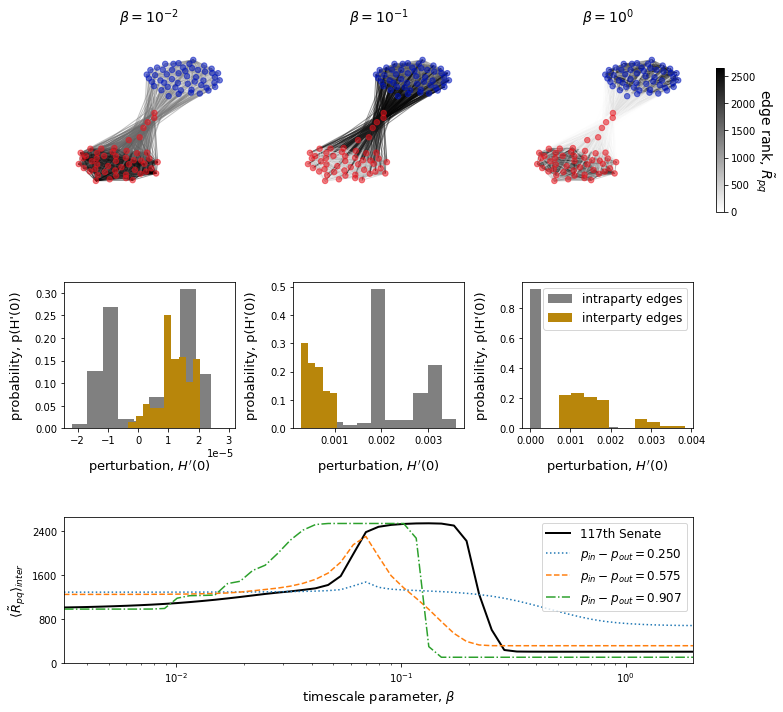

In [41]:
fig = plt.figure(figsize = (10, 10))
gs = fig.add_gridspec(3, 3)

axs1 = fig.add_subplot(gs[0, 0])
axs2 = fig.add_subplot(gs[0, 1])
axs3 = fig.add_subplot(gs[0, 2])

_, ax1 = nx_graph(G, pos, ranks_avg, fig, axs1, node_colors)
_, ax2 = nx_graph(G, pos, ranks_max, fig, axs2, node_colors)
_, ax3 = nx_graph(G, pos, ranks_min, fig, axs3, node_colors, coloring = True)

axs1.set_title(r'$\beta = %s$' % r'10^{-2}' + '\n', fontsize = 14)
remove_axis(axs1)
axs2.set_title(r'$\beta = %s$' % r'10^{-1}' + '\n', fontsize = 14)
remove_axis(axs2)
axs3.set_title(r'$\beta = %s$' % r'10^{0}' + '\n', fontsize = 14)
remove_axis(axs3)

axs4 = fig.add_subplot(gs[1, 0])
axs5 = fig.add_subplot(gs[1, 1])
axs6 = fig.add_subplot(gs[1, 2])

norm_hist(Hs_avg, con_locs, axs4, color = 'grey', label = 'intraparty edges')
norm_hist(Hs_max, con_locs, axs5, color = 'grey', label = 'intraparty edges')
norm_hist(Hs_min, con_locs, axs6, color = 'grey', label = 'intraparty edges')

norm_hist(Hs_avg, ~con_locs, axs4, color = 'darkgoldenrod', label = 'interparty edges')
norm_hist(Hs_max, ~con_locs, axs5, color = 'darkgoldenrod', label = 'interparty edges', bins = 5)
norm_hist(Hs_min, ~con_locs, axs6, color = 'darkgoldenrod', label = 'interparty edges')

axs4.set_ylabel('probability, p(H\'(0))', fontsize = 13, labelpad = 12)
axs4.set_xlabel(r"perturbation, $H'(0)$", fontsize = 13, labelpad = 12)
axs4.xaxis.set_major_locator(plt.MaxNLocator(6))

axs5.set_ylabel('probability, p(H\'(0))', fontsize = 13, labelpad = 12)
axs5.set_xlabel(r"perturbation, $H'(0)$", fontsize = 13, labelpad = 12)

axs6.set_ylabel('probability, p(H\'(0))', fontsize = 13, labelpad = 12)
axs6.set_xlabel(r"perturbation, $H'(0)$", fontsize = 13, labelpad = 12)
axs6.legend(loc = 'upper right', fontsize = 12)

axs7 = fig.add_subplot(gs[2:, :])

axs7.semilogx(betas, con_ranks, label = r'117th Senate', lw = 2, c = 'k')
axs7.semilogx(betas, ranks1, label = r'$p_{in} - p_{out} = $' + str(0.250) + '0', lw = 1.5, ls = ':')
axs7.semilogx(betas, ranks2, label = r'$p_{in} - p_{out} = $' + str(round(delta2, 3)), lw = 1.5, ls = '--')
axs7.semilogx(betas, ranks3, label = r'$p_{in} - p_{out} = $' + str(round(delta, 3)), lw = 1.5, ls = '-.')

axs7.set_xlim(10**(-2.5), betas[-1])
axs7.set_ylim(0)
axs7.set_ylabel(r'$\langle \tilde{R}_{pq}\rangle_{inter}$', fontsize = 13)
axs7.set_xlabel(r'timescale parameter, $\beta$', fontsize = 13)
axs7.yaxis.set_major_locator(plt.MaxNLocator(4))
axs7.set_title('\n')
axs7.legend(loc = 'upper right', fontsize = 12, frameon = True)

fig.tight_layout()

if save == True:
    fig.savefig('figs/congressional_sbm.pdf', bbox_inches='tight')

---